In [1]:
# Install xgboost in notebook instance.
!pip install xgboost==1.2
!pip install imbalanced-learn==0.9.1

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


# 1. Import required libraries

In [2]:
# Import required dependencies
import boto3
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb_lib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import sklearn

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
 
from collections import Counter
import shap

# 2. Read data

In [3]:
# Readind data
bucket_name = 'finance-factoring-ml-dev'

df = pd.read_csv('s3://{}/data/all.csv'.format(bucket_name))
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,FechaPago
0,1918.0,DDI140206JB6,0,1,1953.0,38879.48,33047.56,2351.94,1939.0
1,1634.0,GOSJ630117VA4,1,0,1654.0,6658.40,5659.64,109.45,1638.0
2,1583.0,ECM190924RS5,2,1,1551.0,791.12,791.12,29.26,1551.0
3,2282.0,DIM9811232SA,3,0,2225.0,33048.00,28090.80,814.88,2226.0
4,2110.0,SNO200526BV7,4,0,2170.0,424634.82,360939.60,10615.87,2166.0


# 3. Data Engineering

In [4]:
# Remove RFC Columns
df.drop("RFCPagador", axis=1, inplace=True)
df.drop("Moneda", axis=1, inplace=True)
df.drop("DepositoInicial", axis=1, inplace=True)
df.drop("Intereses", axis=1, inplace=True)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0


In [5]:
# Build feature Payment term
def calc_payment_term(row):
    return row.FechaVencimiento - row.Fecha

df['PaymentTerm'] = df.apply(calc_payment_term, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0


In [6]:
# Build feature Number of total paid invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha)]
    
    return len(df_filtered.index)

df['NumberTotalPaidInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9


In [7]:
# Build feature Number of invoices that were paid late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha)  & (df.FechaPago > df.FechaVencimiento)]
    
    return len(df_filtered.index)

df['NumberInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0


In [8]:
# Build feature Ratio of paid invoices that were late
def calc_delta(row):
    if row.NumberTotalPaidInvoices == 0:
        return 0
    else:
        return row.NumberInvoicesPaidLate / row.NumberTotalPaidInvoices

df['RatioInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000


In [9]:
# Build feature Sum of the base amount of total paid invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha)]
    
    return df_filtered.Monto.sum()

df['SumAmountTotalPaidInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72


In [10]:
# Build feature Sum of the base amount of invoices that were paid late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > df.FechaVencimiento)]
    
    return df_filtered.Monto.sum()

df['SumAmountInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00


In [11]:
# Build feature Ratio of sum of paid base amount that were late
def calc_delta(row):
    if row.SumAmountTotalPaidInvoices == 0:
        return 0
    else:
        return row.SumAmountInvoicesPaidLate / row.SumAmountTotalPaidInvoices

df['RatioSumAmountInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80,0.109457
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00,0.000000
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00,0.000000


In [12]:
# Build feature Average days late of paid invoices being late.
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > df.FechaVencimiento)]
  
    df_filtered['DaysLate'] = df_filtered['FechaPago'] - df_filtered['FechaVencimiento']
    
    if len(df_filtered.index) == 0:
        return 0
    else:
        return df_filtered.DaysLate.mean()

df['AvgDaysLateInvoicesPaidLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000


In [13]:
# Build feature Number of total outstanding invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > row.Fecha)]
  
    return len(df_filtered.index)

df['NumberTotalOutstandingInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0


In [14]:
# Build feature Number of outstanding invoices that were already late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > df.FechaVencimiento) & (df.FechaPago > row.Fecha)]
  
    return len(df_filtered.index)

df['NumberOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0


In [15]:
# Build feature Ratio of outstanding invoices that were late
def calc_delta(row):
    if row.NumberTotalOutstandingInvoices == 0:
        return 0
    else:
        return row.NumberOutstandingLateInvoices / row.NumberTotalOutstandingInvoices

df['RatioOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000


In [16]:
# Build feature Sum of the base amount of total outstanding invoices
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > row.Fecha)]
  
    return df_filtered.Monto.sum()

df['SumAmountTotalOutstandingInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00


In [17]:
# Build feature Sum of the base amount of outstanding invoices that were late
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > row.Fecha) & (df.FechaPago > df.FechaVencimiento)]
  
    return df_filtered.Monto.sum()

df['SumAmountOutstandingLateInvoices'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33,249381.40
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95,549081.45
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00


In [18]:
# Build feature Ratio of sum of outstanding base amount that were late
def calc_delta(row):
    if row.SumAmountTotalOutstandingInvoices == 0:
        return 0
    else:
        return row.SumAmountOutstandingLateInvoices / row.SumAmountTotalOutstandingInvoices

df['RatioSumAmountOutstandingLateInvoice'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33,249381.40,0.488888
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80,0.109457
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95,549081.45,0.500162
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000


In [19]:
# Build feature Average days late of outstanding invoices being late.
def calc_delta(row):
    df_filtered = df[(df.RFCCliente == row.RFCCliente) & (df.Fecha < row.Fecha) & (df.FechaPago > df.FechaVencimiento) & (df.FechaPago > row.Fecha)]
  
    df_filtered['DaysLate'] = df_filtered['FechaPago'] - df_filtered['FechaVencimiento']
    
    if len(df_filtered.index) == 0:
        return 0
    else:
        return df_filtered.DaysLate.mean()

df['AvgDaysLateOutstandingInvoicesBeingLate'] = df.apply(calc_delta, axis=1)
df.head()

,Fecha,RFCCliente,FechaVencimiento,Monto,FechaPago,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate
0,1918.0,DDI140206JB6,1953.0,38879.48,1939.0,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33,249381.40,0.488888,19.400000
1,1634.0,GOSJ630117VA4,1654.0,6658.40,1638.0,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80,0.109457,7.000000
2,1583.0,ECM190924RS5,1551.0,791.12,1551.0,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000,0.000000
3,2282.0,DIM9811232SA,2225.0,33048.00,2226.0,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95,549081.45,0.500162,4.333333
4,2110.0,SNO200526BV7,2170.0,424634.82,2166.0,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000,0.000000


# 4. Prepare dataframes for modeling approaches

## 3.1 Build temporary **DaysLate** column

In [20]:
def calc_delta(row):
    days = (row['FechaPago'] - row['FechaVencimiento'])
    return days

df['DaysLate'] = df.apply(calc_delta, axis=1)

# Remove "FechaPago" and RFCCliente features
df.drop("FechaPago", axis=1, inplace=True)
df.drop("RFCCliente", axis=1, inplace=True)

df.head()

,Fecha,FechaVencimiento,Monto,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate,DaysLate
0,1918.0,1953.0,38879.48,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33,249381.40,0.488888,19.400000,-14.0
1,1634.0,1654.0,6658.40,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,-16.0
2,1583.0,1551.0,791.12,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000,0.000000,0.0
3,2282.0,2225.0,33048.00,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95,549081.45,0.500162,4.333333,1.0
4,2110.0,2170.0,424634.82,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000,0.000000,-4.0


## 3.2 Build target column **PaidTime**
> * 1: Pay before time
> * 2: On time
> * 3: Late payment 1-7 days
> * 4: Late payment 8-21 days
> * 5: Late payment > 21 days

In [21]:
def build_paidTime(row):
    if row.DaysLate < 0:
        return 1
    if row.DaysLate == 0:
        return 2
    if row.DaysLate <= 7:
        return 3
    if row.DaysLate <= 21:
        return 4
    else:
        return 5

df['PaidTime'] = df.apply(build_paidTime, axis=1)

df.head()

,Fecha,FechaVencimiento,Monto,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate,DaysLate,PaidTime
0,1918.0,1953.0,38879.48,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33,249381.40,0.488888,19.400000,-14.0,1
1,1634.0,1654.0,6658.40,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,-16.0,1
2,1583.0,1551.0,791.12,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000,0.000000,0.0,2
3,2282.0,2225.0,33048.00,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95,549081.45,0.500162,4.333333,1.0,3
4,2110.0,2170.0,424634.82,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000,0.000000,-4.0,1


In [22]:
# Remove "DaysLate" because it's not gonna be needed anymore
df.drop("DaysLate", axis=1, inplace=True)
df.drop("Fecha", axis=1, inplace=True)
df.drop("FechaVencimiento", axis=1, inplace=True)

df.head()

,Monto,PaymentTerm,NumberTotalPaidInvoices,NumberInvoicesPaidLate,RatioInvoicesPaidLate,SumAmountTotalPaidInvoices,SumAmountInvoicesPaidLate,RatioSumAmountInvoicesPaidLate,AvgDaysLateInvoicesPaidLate,NumberTotalOutstandingInvoices,NumberOutstandingLateInvoices,RatioOutstandingLateInvoices,SumAmountTotalOutstandingInvoices,SumAmountOutstandingLateInvoices,RatioSumAmountOutstandingLateInvoice,AvgDaysLateOutstandingInvoicesBeingLate,PaidTime
0,38879.48,35.0,297,67,0.225589,6888834.31,1687615.30,0.244978,15.701493,20,10,0.500000,510099.33,249381.40,0.488888,19.400000,1
1,6658.40,20.0,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,18,4,0.222222,537358.40,58817.80,0.109457,7.000000,1
2,791.12,-32.0,7,0,0.000000,8373.86,0.00,0.000000,0.000000,4,0,0.000000,4110.39,0.00,0.000000,0.000000,2
3,33048.00,-57.0,774,228,0.294574,26762583.68,12413230.36,0.463828,5.701754,36,6,0.166667,1097807.95,549081.45,0.500162,4.333333,3
4,424634.82,60.0,9,0,0.000000,2340876.72,0.00,0.000000,0.000000,0,0,0.000000,0.00,0.00,0.000000,0.000000,1


## 3.3 Separate target for predictions

In [35]:
X = df.drop(['PaidTime'], axis=1)
y = df.PaidTime

In [24]:
# Break off validation set from training data set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Trainging dataset shape:  (14966, 16)
Test dataset shape:  (3742, 16)


# 4. Helper functions

In [25]:
# Helper function to plot confusion matrix
def render_confusion_matrix(y_test_input, predicted, clasess):
    ac_s = accuracy_score(y_test_input, predicted) * 100
    print('The Accuracy is: ', ac_s, " %")

    cm = confusion_matrix(y_test_input, predicted, labels=clasess)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clasess)
    disp.plot()
    return ac_s

In [26]:
# Helper function to plot models accuracies
def plot_models_accuracy(models_name, accuracies):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(models_name,accuracies)
    _ = plt.xticks(rotation=90,fontsize=14)
    plt.title('Compare accuracy (test)')
    plt.ylim(70, 100)
    plt.show()   

# 5. Test models

## 5.1 Decision Tree Classifier

The Accuracy is:  80.59861036878675  %


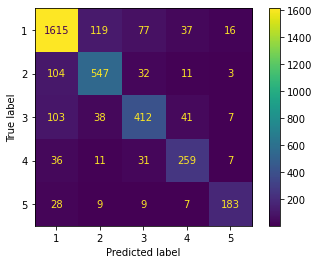

In [27]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

predicted_tree = tree.predict(X_test)

ac_dtc = render_confusion_matrix(y_test, predicted_tree, tree.classes_)

### 5.1.1 Shap values for Decision Tree Classifier

In [199]:
# Fits the explainer
explainer = shap.Explainer(tree.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 3743it [02:09, 27.29it/s]                          


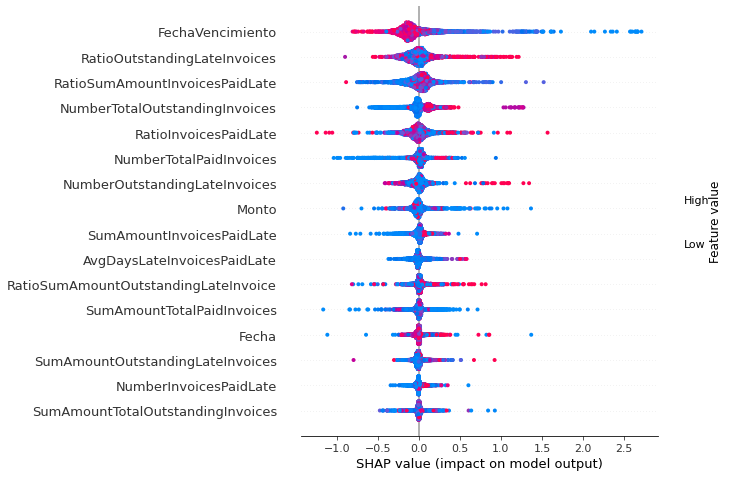

In [30]:
shap.summary_plot(shap_values)

## 5.2 Random Forests Classifier

The Accuracy is:  83.1640833778728  %


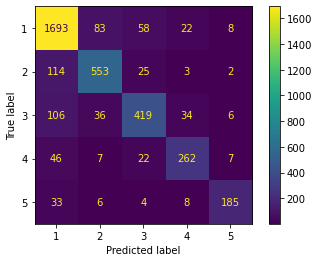

In [28]:
#Create a Gaussian Classifier
rf_clf=RandomForestClassifier(n_estimators=200, random_state=0)

#Attach feature names to the model 
rf_clf.feature_names_ = list(X_train.columns.values)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf.fit(X_train, y_train)

predicted_rf=rf_clf.predict(X_test)

ac_rfc = render_confusion_matrix(y_test, predicted_rf, rf_clf.classes_)

In [314]:
importances = rf_clf.feature_importances_

# Summarize feature importance    
forest_importances = pd.Series(importances, index=rf_clf.feature_names_)
print(forest_importances)

Monto                                      0.146687
PaymentTerm                                0.168526
NumberTotalPaidInvoices                    0.066964
NumberInvoicesPaidLate                     0.049317
RatioInvoicesPaidLate                      0.060918
SumAmountTotalPaidInvoices                 0.059632
SumAmountInvoicesPaidLate                  0.041738
RatioSumAmountInvoicesPaidLate             0.060567
AvgDaysLateInvoicesPaidLate                0.054992
NumberTotalOutstandingInvoices             0.049620
NumberOutstandingLateInvoices              0.030289
RatioOutstandingLateInvoices               0.055496
SumAmountTotalOutstandingInvoices          0.048708
SumAmountOutstandingLateInvoices           0.027352
RatioSumAmountOutstandingLateInvoice       0.041435
AvgDaysLateOutstandingInvoicesBeingLate    0.037759
dtype: float64


### 5.2.1 Shap values for Random Forests Classifier

In [33]:
# Fits the explainer
explainer = shap.Explainer(rf_clf.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_rfc = explainer(X_test)

Permutation explainer: 3743it [49:21,  1.26it/s]                           


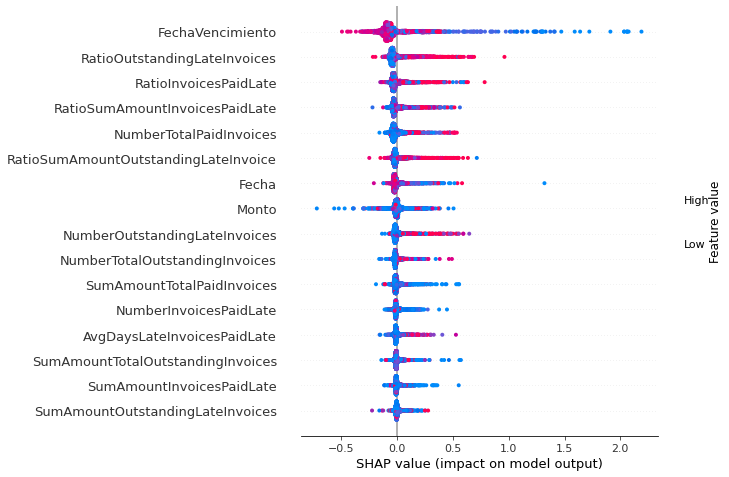

In [34]:
shap.summary_plot(shap_values_rfc)

## 5.3 XGBoost Classifier

The Accuracy is:  80.38482095136291  %


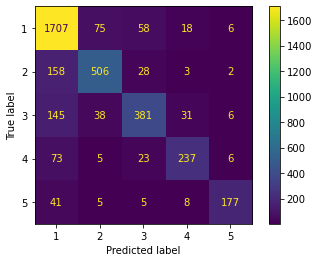

In [316]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

predicted_xgb = xgb.predict(X_test)

ac_xgbc = render_confusion_matrix(y_test, predicted_xgb, xgb.classes_)

### 5.3.1 Shap values for XGBoost Classifier

In [37]:
# Fits the explainer
explainer = shap.Explainer(xgb.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_xgb = explainer(X_test)

Permutation explainer: 3743it [1:01:08,  1.02it/s]                          


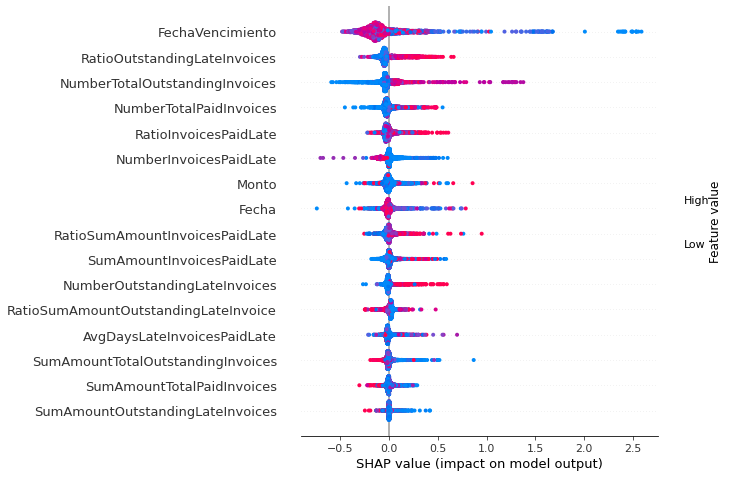

In [38]:
shap.summary_plot(shap_values_xgb)

# 6. Models accuracies

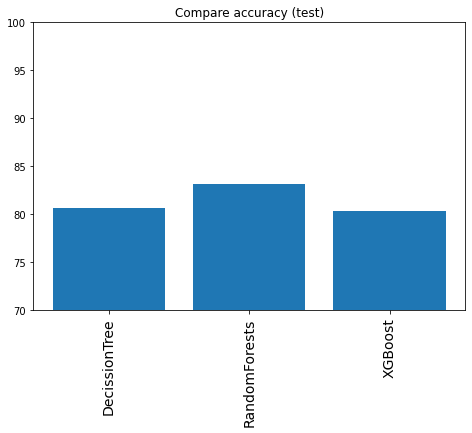

[80.70550507749866, 83.1640833778728, 80.38482095136291]


In [317]:
# Models accuracies
accuracies = [ac_dtc, ac_rfc, ac_xgbc]
models_name = ['DecissionTree', 'RandomForests', 'XGBoost']
plot_models_accuracy(models_name, accuracies)
print(accuracies)

# 7. Working with Invoice level features only

## 7.1 Extracting invoice level features

In [39]:
X_invoice_level_features = df.loc[:, ['Monto', 'PaymentTerm']]
X_invoice_level_features.head()

,Monto,PaymentTerm
0,38879.48,35.0
1,6658.40,20.0
2,791.12,-32.0
3,33048.00,-57.0
4,424634.82,60.0


In [40]:
# Break off validation set from training data set
X_train, X_test, y_train, y_test = train_test_split(X_invoice_level_features, y, train_size=0.8, test_size=0.2, random_state=0)
print('Trainging dataset shape: ', X_train.shape)
print('Test dataset shape: ', X_test.shape)

Trainging dataset shape:  (14966, 2)
Test dataset shape:  (3742, 2)


## 7.2 Use the selected algorithm

The Accuracy is:  51.36290753607696  %


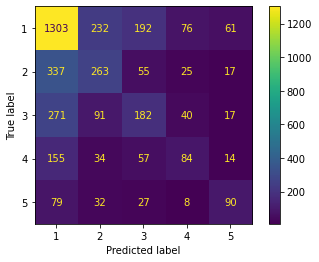

In [45]:
#Create a Gaussian Classifier
rf_clf_invoice_level = RandomForestClassifier(n_estimators=200, random_state=0)

#Attach feature names to the model 
rf_clf_invoice_level.feature_names_ = list(X_train.columns.values)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf_invoice_level.fit(X_train, y_train)

predicted_rf_invoice_level = rf_clf_invoice_level.predict(X_test)

ac_rfc_invoice_level = render_confusion_matrix(y_test, predicted_rf_invoice_level, rf_clf_invoice_level.classes_)

# 8. Working with Invoice + Customer + History level features

In [47]:
# TODO

# 9. Save the selected model

In [318]:
import joblib

model_name = 'model.joblib'
with open(model_name, 'wb') as f:
    joblib.dump(rf_clf, f)

print("Model was saved.")

with open('model.joblib', 'rb') as f:
    predictor = joblib.load(f)

df_predict = X_test.iloc[0:1]

print('Prediction:', predictor.predict(df_predict))

Model was saved.
Prediction: [1]


# 10. Model Deployment Script

In [320]:
import json
import os
import joblib
import pickle
import tarfile
import sagemaker
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
import time
from time import gmtime, strftime
import subprocess

In [321]:
#Setup
client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")
boto_session = boto3.session.Session()

s3_resource = boto3.Session().resource('s3')
region = boto_session.region_name
print(region)
sagemaker_session = sagemaker.Session()

role = get_execution_role()
print(role)

us-west-2
arn:aws:iam::244210425001:role/service-role/AmazonSageMaker-ExecutionRole-20220610T101490


In [322]:
bashCommand = "tar -cvpzf model.tar.gz model.joblib inference.py"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [323]:
#Upload tar.gz to bucket
model_artifacts = f"s3://{bucket_name}/output/multiclass-clasification/model/model.tar.gz"

response = s3_resource.meta.client.upload_file('model.tar.gz', bucket_name, 'output/multiclass-clasification/model/model.tar.gz')
# TODO Remove model.joblib and model.tar.gz if they will no longer needed

In [324]:
region = boto3.Session().region_name

# Retrieve sklearn image
image_uri = sagemaker.image_uris.retrieve(
    framework="sklearn",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)

In [325]:
#Step 1: Model Creation
model_name = "sklearn-test" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)
create_model_response = client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": image_uri,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": {'SAGEMAKER_SUBMIT_DIRECTORY': model_artifacts,
                           'SAGEMAKER_PROGRAM': 'inference.py'} 
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

Model name: sklearn-test2022-10-31-18-30-30
Model Arn: arn:aws:sagemaker:us-west-2:244210425001:model/sklearn-test2022-10-31-18-30-30


In [326]:
#Step 2: EPC Creation
sklearn_epc_name = "sklearn-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=sklearn_epc_name,
    ProductionVariants=[
        {
            "VariantName": "sklearnvariant",
            "ModelName": model_name,
            "InstanceType": "ml.c5.large",
            "InitialInstanceCount": 1
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-west-2:244210425001:endpoint-config/sklearn-epc2022-10-31-18-30-34


In [327]:
#Step 3: EP Creation
endpoint_name = "sklearn-local-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=sklearn_epc_name,
)
print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

#Monitor creation
describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)
print(describe_endpoint_response)

Endpoint Arn: arn:aws:sagemaker:us-west-2:244210425001:endpoint/sklearn-local-ep2022-10-31-18-30-39
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService
{'EndpointName': 'sklearn-local-ep2022-10-31-18-30-39', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:244210425001:endpoint/sklearn-local-ep2022-10-31-18-30-39', 'EndpointConfigName': 'sklearn-epc2022-10-31-18-30-34', 'ProductionVariants': [{'VariantName': 'sklearnvariant', 'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3', 'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-scikit-learn@sha256:e7887de688db0abeb4ae7f0467d18c69c613d3795bc23c425ec0574b19b81350', 'ResolutionTime': datetime.datetime(2022, 10, 31, 18, 30, 41, 60000, tzinfo=tzlocal())}], 'CurrentWeight': 1.0, 'DesiredWeight': 1.0, 'CurrentInstanceCount': 1, 'DesiredInstanceCount': 1}], 'EndpointStatus': 'InService', 'CreationTime': datetime.datetim

# 11. Model invocation

In [329]:
row = X_test.iloc[0:1]
# row = [200.0,2018.0,37400.0,445,17,50,12874467.33,206333.52,0.016027,103.0,49,1,0.020408,5,4,0.00144]
row = row.values[0].tolist()
print(row)

[37400.0, 65.0, 445.0, 17.0, 0.038202247191011236, 12874467.33, 206333.52000000002, 0.016026567524017325, 100.3529411764706, 49.0, 1.0, 0.02040816326530612, 2423289.33, 3489.28, 0.001439894096343832, 103.0]


In [331]:
import boto3
import json
print(endpoint_name)
# endpoint_name = 'sklearn-local-ep2022-10-10-15-53-04'
runtime_client = boto3.client('sagemaker-runtime')
content_type = "application/json"
# request_body = {"Input": [[0.09178, 0.0, 4.05, 0.0, 0.51, 6.416, 84.1, 2.6463, 5.0, 296.0, 16.6, 395.5, 9.04]]}

request_body = {"Input": [row]}

data = json.loads(json.dumps(request_body))
payload = json.dumps(data)

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType=content_type,
    Body=payload)
result = json.loads(response['Body'].read().decode())
print(result['Output'])

sklearn-local-ep2022-10-31-18-30-39
[1]


# Clean up
## Deleting the endpoint
Once that we're donde predicting, we can delete the endpoint (and stop paying for it). We can re-deploy again by running the appropiate cell above.

In [305]:
sagemaker.Session().delete_endpoint(endpoint_name=endpoint_name)
sagemaker.Session().delete_endpoint_config(sklearn_epc_name)